In [1]:
from env import RouterEnv
from bandit import EmpiricalEstimator, PerArmExploration, NeuralEstimator, Algorithm
from lightning_lite.utilities.seed import seed_everything
import numpy as np
import matplotlib.pyplot as plt

/home/vlongle/miniconda3/envs/data-sharing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(0)
num_tasks = 2
num_cls = 10
reduce_fator = 2
num_candidates = 64
num_slates = num_candidates // reduce_fator
num_samples = 24000
# existing_samples = np.array([[0, 0],
#                             [10, 10]])
# target_samples = np.array([[10, 10],
#                            [10, 10]])
num_data_sent = num_samples // reduce_fator
target_samples = np.ones((num_tasks, num_cls)) * (num_data_sent // num_cls)
existing_samples = np.zeros((num_tasks, num_cls))
existing_samples[1, :] = target_samples[1, :]
print(target_samples)
print(existing_samples)

env = RouterEnv(existing_samples, target_samples,
                cfg={"num_candidates": num_candidates,
                        "num_samples": num_samples,
                        "num_slates": num_slates,
                        "num_tasks": num_tasks,
                        "num_classes": num_cls, })

# estimator = EmpiricalEstimator(num_tasks, num_cls)
estimator = NeuralEstimator(num_tasks, num_cls)
explore = PerArmExploration(num_tasks, num_cls, num_slates)
algo = Algorithm(
    estimator,
    explore,
)
obs = env.reset()
# print("initial obs:", obs)
done = False
step_rewards = []
pred_losses = []
while not done:
    action = algo.predict(obs)
    next_obs, reward, done, info = env.step(action)
    # print("obs:", obs, "action", action, "next_obs",
    #       next_obs, "reward", info["rewards"], "done", done)
    algo.update_estimator(obs, action, info["rewards"])
    obs = next_obs
    step_rewards.append(reward)
    pred_loss = (algo.estimator.Q - env.Q) ** 2
    pred_losses.append(pred_loss)

print("current samples after training:")
print(env.current_samples)
routed_data = env.current_samples - existing_samples
print("routed data:")
print(routed_data)
pred_losses = np.array(pred_losses)

Global seed set to 0


[[1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.]
 [1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.]]
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.]]
current samples after training:
[[ 984. 1009. 1078. 1048. 1112. 1089. 1090. 1040. 1008. 1051.]
 [1321. 1351. 1305. 1295. 1297. 1288. 1296. 1321. 1303. 1325.]]
routed data:
[[ 984. 1009. 1078. 1048. 1112. 1089. 1090. 1040. 1008. 1051.]
 [ 121.  151.  105.   95.   97.   88.   96.  121.  103.  125.]]


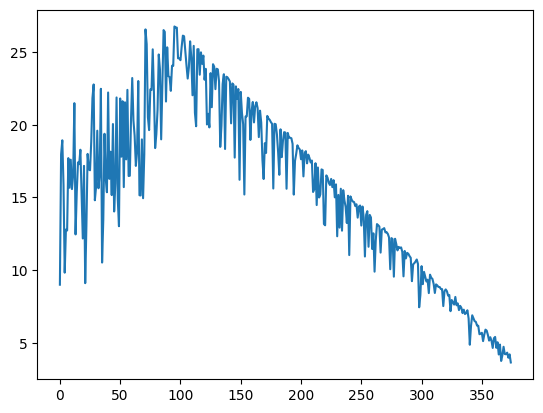

In [3]:
plt.plot(step_rewards);

In [4]:
pred_losses.shape

(375, 2, 10)

/tmp/ipykernel_26349/2193123409.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


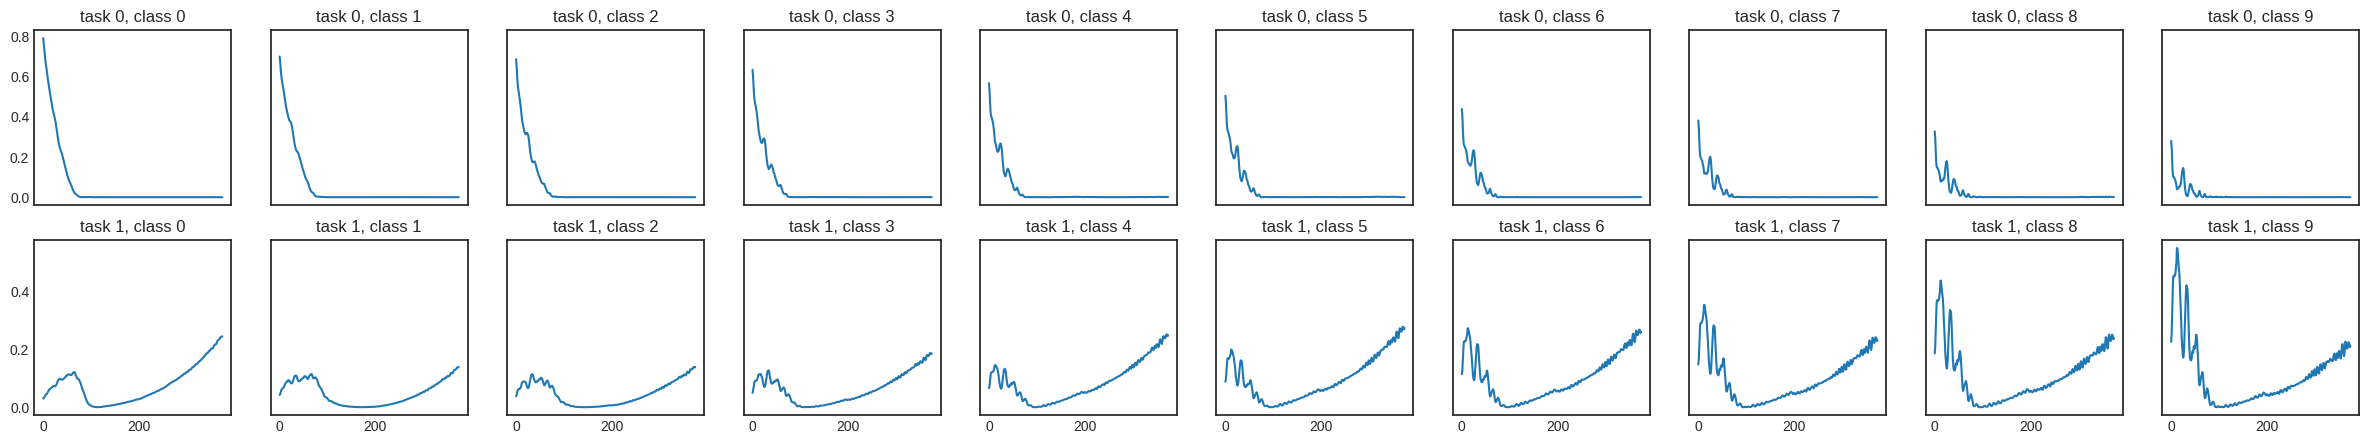

In [5]:
"""
plot gradient red for task 0 and blue for task 1
"""
from matplotlib.pyplot import figure

plt.style.use('seaborn-white')


fig, ax = plt.subplots(2, 10, sharex='col', sharey='row', figsize=(30, 5))
for i in range(2):
    for j in range(10):
        ax[i, j].plot(pred_losses[:, i, j])
        ax[i, j].set_title(f"task {i}, class {j}")

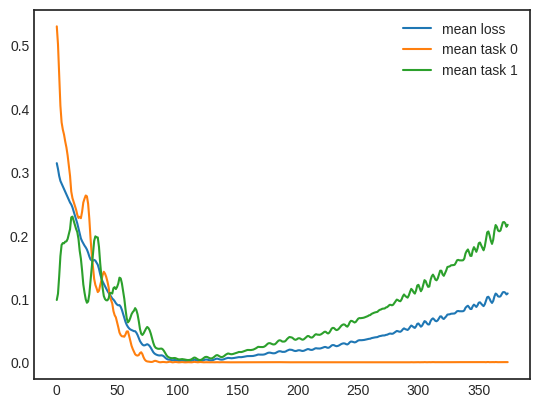

In [6]:
# calculate the mean loss over time
mean_loss = np.mean(pred_losses, axis=(1, 2))
mean_task_0 = np.mean(pred_losses[:, 0, :], axis=1)
mean_task_1 = np.mean(pred_losses[:, 1, :], axis=1)
plt.plot(mean_loss, label="mean loss")
plt.plot(mean_task_0, label="mean task 0")
plt.plot(mean_task_1, label="mean task 1")
plt.legend();

In [7]:
print("mean_rewards:", np.mean(step_rewards))
print("mean_loss:", np.mean(mean_loss))
print("mean_task_0:", np.mean(mean_task_0))
print("mean_task_1:", np.mean(mean_task_1))

mean_rewards: 15.644464444444447
mean_loss: 0.058009814705189455
mean_task_0: 0.03213313050643352
mean_task_1: 0.08388649890394537


Neural Estimator:

    - mean_rewards: 15.644464444444447
    - mean_loss: 0.058009814705189455
    - mean_task_0: 0.03213313050643352
    - mean_task_1: 0.08388649890394537

Empirical Estimator:

    - mean_rewards: 15.956702222222223
    - mean_loss: 0.03677569409233054
    - mean_task_0: 0.07341963226219289
    - mean_task_1: 0.00013175592246817766